<a href="https://colab.research.google.com/github/aulialigar/Capstone_SIB_Dicoding/blob/main/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/data.zip -d data/

Archive:  drive/MyDrive/data.zip
  inflating: data/test_data_classification.csv  
  inflating: data/train_data_classification.csv  
  inflating: data/data_forecasting_final.csv  


Menampilkan dataset

In [4]:
df = pd.read_csv("data/data_forecasting_final.csv")
df

,tanggal,pm10,so2,co,o3,no2
0,2010-01-01,60.0,4.0,73.0,27.0,14.0
1,2010-01-02,32.0,2.0,16.0,33.0,9.0
2,2010-01-03,27.0,2.0,19.0,20.0,9.0
3,2010-01-04,22.0,2.0,16.0,15.0,6.0
4,2010-01-05,25.0,2.0,17.0,15.0,8.0
...,...,...,...,...,...,...
4225,2021-07-27,82.0,56.0,13.0,41.0,35.0
4226,2021-07-28,82.0,53.0,18.0,40.0,45.0
4227,2021-07-29,78.0,52.0,18.0,53.0,39.0
4228,2021-07-30,90.0,54.0,15.0,81.0,35.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230 entries, 0 to 4229
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  4230 non-null   object 
 1   pm10     4230 non-null   float64
 2   so2      4230 non-null   float64
 3   co       4230 non-null   float64
 4   o3       4230 non-null   float64
 5   no2      4230 non-null   float64
dtypes: float64(5), object(1)
memory usage: 198.4+ KB


In [6]:
df.tanggal = pd.to_datetime(df.tanggal)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230 entries, 0 to 4229
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   tanggal  4230 non-null   datetime64[ns]
 1   pm10     4230 non-null   float64       
 2   so2      4230 non-null   float64       
 3   co       4230 non-null   float64       
 4   o3       4230 non-null   float64       
 5   no2      4230 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 198.4 KB


In [8]:
df.describe()

,pm10,so2,co,o3,no2
count,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000
mean,65.613841,27.801089,32.123599,93.409482,19.446529
std,18.922869,15.554703,13.044231,47.957399,13.216514
min,19.000000,2.000000,5.000000,9.000000,3.000000
25%,55.000000,17.000000,23.000000,60.000000,13.000000
50%,65.000000,26.000000,30.000000,84.000000,17.000000
75%,75.000000,33.000000,38.000000,116.000000,21.000000
max,178.000000,126.000000,134.000000,314.000000,148.000000


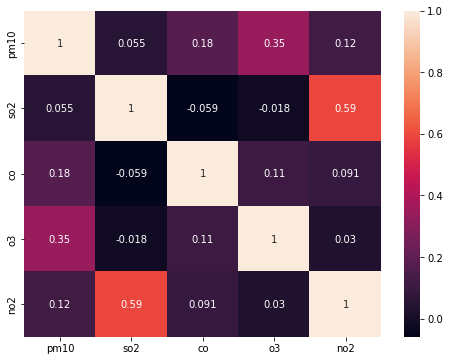

In [9]:
plt.figure(figsize=(8,6))

sns.heatmap(df.corr(), annot=True)

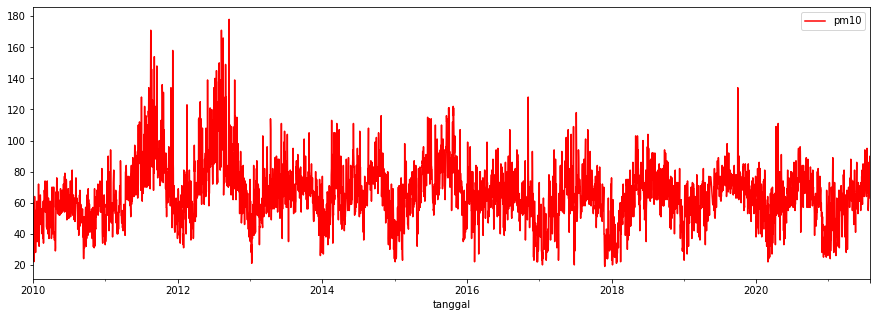

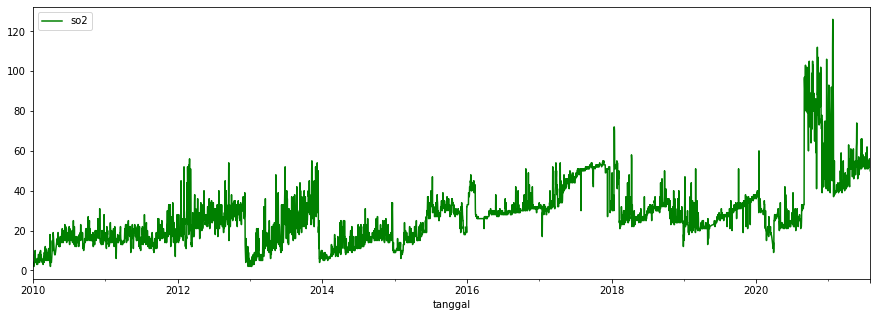

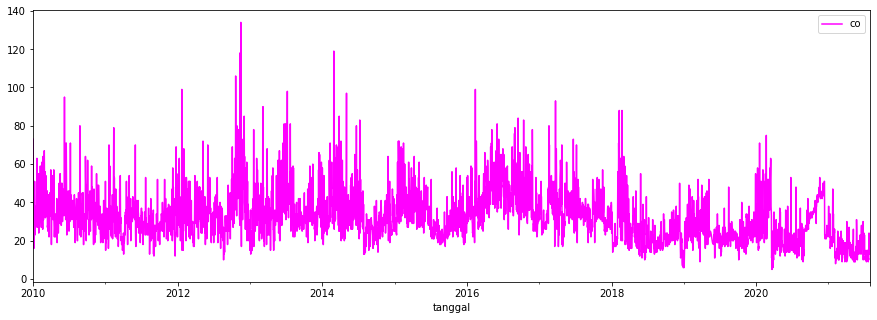

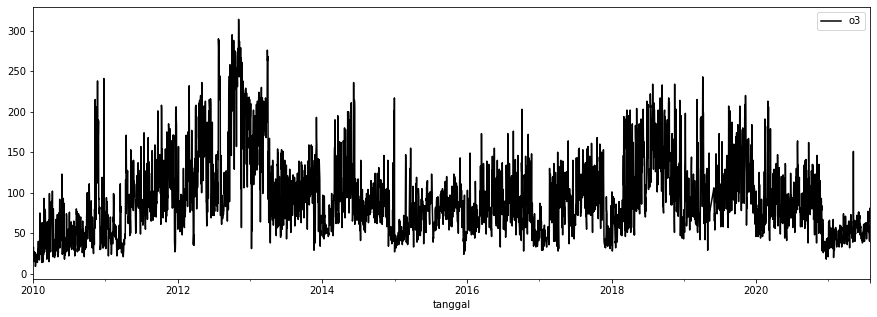

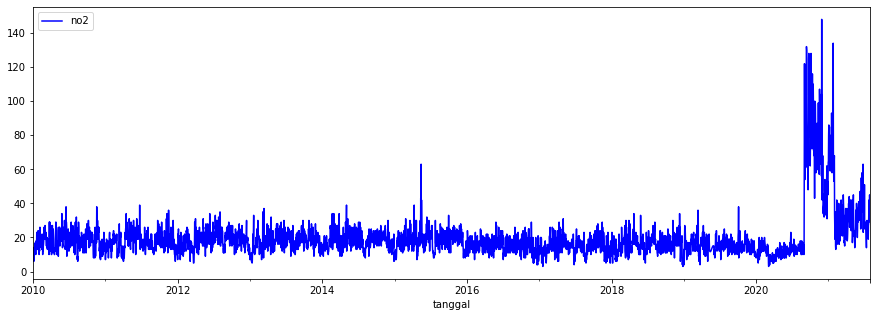

In [10]:
df_resample = (df.set_index('tanggal')).resample('D').mean().reset_index()

df_resample.plot(x='tanggal', y='pm10', kind='line', color='red', figsize=(15,5))
df_resample.plot(x='tanggal', y='so2', kind='line', color='green', figsize=(15,5))
df_resample.plot(x='tanggal', y='co', kind='line', color='magenta', figsize=(15,5))
df_resample.plot(x='tanggal', y='o3', kind='line', color='black', figsize=(15,5))
df_resample.plot(x='tanggal', y='no2', kind='line', color='blue', figsize=(15,5))

In [11]:
# Normalization
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [12]:
window_size = 30
batch_size = 8
shuffle_buffer_size = 1000

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
def model_forecast(model, series, batch_size, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

#Variabel pm10

In [15]:
pm10 = df['pm10'].values.reshape(-1, 1)
pm10 = min_max_scaler.fit_transform(pm10)
time = df.index.values + 1

In [16]:
minMAE = (pm10.max() - pm10.min()) * 0.1
minMAE

0.1

In [17]:
split_time = int(0.9 * len(pm10))
time_train = time[:split_time]
x_train = pm10[:split_time]
time_valid = time[split_time:]
x_valid = pm10[split_time:]

In [18]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(3807, 1)


In [19]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(val_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(423, 1)


In [20]:
model_pm10 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_pm10.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model_pm10.fit(train_set, validation_data=(val_set), epochs=100)

Epoch 1/100
473/473 [==============================] - 6s 8ms/step - loss: 0.0366 - mse: 0.0731 - mae: 0.2290 - val_loss: 0.0101 - val_mse: 0.0202 - val_mae: 0.1246
Epoch 2/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0118 - mse: 0.0237 - mae: 0.1153 - val_loss: 0.0048 - val_mse: 0.0097 - val_mae: 0.0807
Epoch 3/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0081 - mse: 0.0162 - mae: 0.0926 - val_loss: 0.0044 - val_mse: 0.0088 - val_mae: 0.0728
Epoch 4/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0073 - mse: 0.0147 - mae: 0.0888 - val_loss: 0.0045 - val_mse: 0.0089 - val_mae: 0.0720
Epoch 5/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0071 - mse: 0.0142 - mae: 0.0880 - val_loss: 0.0045 - val_mse: 0.0090 - val_mae: 0.0719
Epoch 6/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0070 - mse: 0.0140 - mae: 0.0876 - val_loss: 0.0045 - val_mse: 0.0090 - val_mae: 0.0719
Epoch 7/10

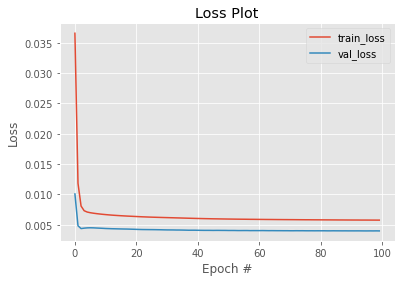

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

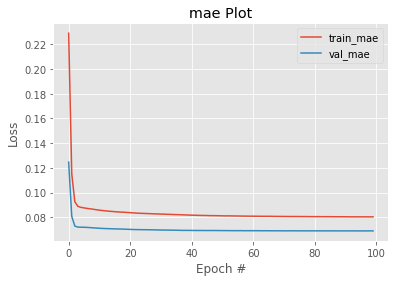

In [23]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mae"], label="train_mae")
plt.plot(np.arange(0, 100), history.history["val_mae"], label="val_mae")
plt.title("mae Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

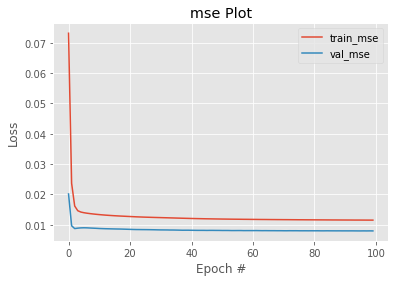

In [24]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mse"], label="train_mse")
plt.plot(np.arange(0, 100), history.history["val_mse"], label="val_mse")
plt.title("mse Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
pm10.shape

(4230, 1)

#Variabel so2

In [26]:
# so2 = df['so2'].values
so2 = df['so2'].values.reshape(-1, 1)
so2 = min_max_scaler.fit_transform(so2)

In [27]:
minMAE = (so2.max() - so2.min()) * 0.1
minMAE

0.1

In [28]:
split_time = int(0.9 * len(so2))
time_train = time[:split_time]
x_train = so2[:split_time]
time_valid = time[split_time:]
x_valid = so2[split_time:]

In [29]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(3807, 1)


In [30]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(val_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(423, 1)


In [31]:
model_so2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_so2.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model_so2.fit(train_set, validation_data=(val_set), epochs=100)

Epoch 1/100
473/473 [==============================] - 5s 8ms/step - loss: 0.0085 - mse: 0.0169 - mae: 0.1082 - val_loss: 0.0490 - val_mse: 0.0980 - val_mae: 0.2663
Epoch 2/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0033 - mse: 0.0066 - mae: 0.0607 - val_loss: 0.0383 - val_mse: 0.0765 - val_mae: 0.2246
Epoch 3/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0028 - mse: 0.0056 - mae: 0.0571 - val_loss: 0.0344 - val_mse: 0.0687 - val_mae: 0.2089
Epoch 4/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0027 - mse: 0.0054 - mae: 0.0564 - val_loss: 0.0326 - val_mse: 0.0653 - val_mae: 0.2018
Epoch 5/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0026 - mse: 0.0052 - mae: 0.0559 - val_loss: 0.0317 - val_mse: 0.0634 - val_mae: 0.1977
Epoch 6/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0026 - mse: 0.0051 - mae: 0.0554 - val_loss: 0.0310 - val_mse: 0.0619 - val_mae: 0.1946
Epoch 7/10

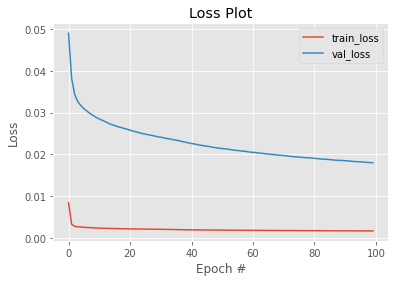

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

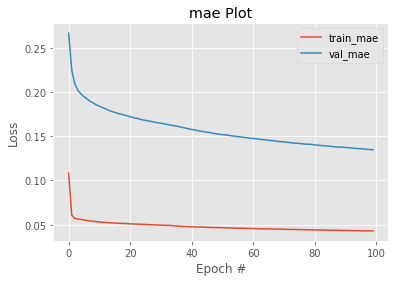

In [34]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mae"], label="train_mae")
plt.plot(np.arange(0, 100), history.history["val_mae"], label="val_mae")
plt.title("mae Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

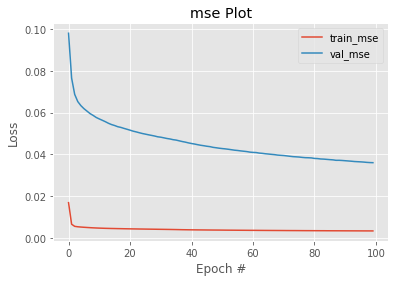

In [35]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mse"], label="train_mse")
plt.plot(np.arange(0, 100), history.history["val_mse"], label="val_mse")
plt.title("mse Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Variabel co

In [36]:
# co = df['co'].values
co = df['co'].values.reshape(-1, 1)
co = min_max_scaler.fit_transform(co)

In [37]:
minMAE = (co.max() - co.min()) * 0.1
minMAE

0.1

In [38]:
split_time = int(0.9 * len(co))
time_train = time[:split_time]
x_train = co[:split_time]
time_valid = time[split_time:]
x_valid = co[split_time:]

In [39]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(3807, 1)


In [40]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(val_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(423, 1)


In [41]:
model_co = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_co.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model_co.fit(train_set, validation_data=(val_set), epochs=100)

Epoch 1/100
473/473 [==============================] - 5s 8ms/step - loss: 0.0121 - mse: 0.0243 - mae: 0.1210 - val_loss: 0.0027 - val_mse: 0.0054 - val_mae: 0.0611
Epoch 2/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0053 - mse: 0.0106 - mae: 0.0727 - val_loss: 0.0035 - val_mse: 0.0070 - val_mae: 0.0740
Epoch 3/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0046 - mse: 0.0092 - mae: 0.0688 - val_loss: 0.0040 - val_mse: 0.0080 - val_mae: 0.0794
Epoch 4/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0045 - mse: 0.0090 - mae: 0.0691 - val_loss: 0.0041 - val_mse: 0.0082 - val_mae: 0.0804
Epoch 5/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0045 - mse: 0.0089 - mae: 0.0693 - val_loss: 0.0042 - val_mse: 0.0083 - val_mae: 0.0808
Epoch 6/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0045 - mse: 0.0089 - mae: 0.0693 - val_loss: 0.0041 - val_mse: 0.0082 - val_mae: 0.0802
Epoch 7/10

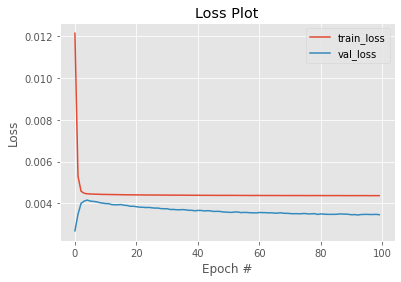

In [43]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

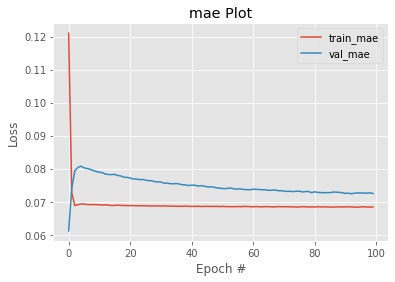

In [44]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mae"], label="train_mae")
plt.plot(np.arange(0, 100), history.history["val_mae"], label="val_mae")
plt.title("mae Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

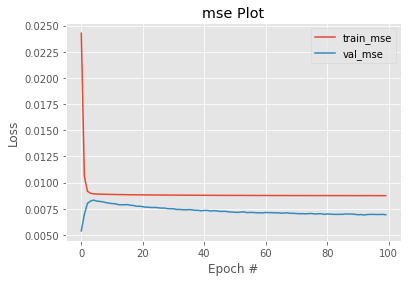

In [45]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mse"], label="train_mse")
plt.plot(np.arange(0, 100), history.history["val_mse"], label="val_mse")
plt.title("mse Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Variabel o3

In [46]:
# o3 = df['o3'].values
o3 = df['o3'].values.reshape(-1, 1)
o3 = min_max_scaler.fit_transform(o3)

In [47]:
minMAE = (o3.max() - o3.min()) * 0.1
minMAE

0.1

In [48]:
split_time = int(0.9 * len(o3))
time_train = time[:split_time]
x_train = o3[:split_time]
time_valid = time[split_time:]
x_valid = o3[split_time:]

In [49]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(3807, 1)


In [50]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(val_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(423, 1)


In [51]:
model_o3 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [52]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_o3.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model_o3.fit(train_set, validation_data=(val_set), epochs=100)

Epoch 1/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0290 - mse: 0.0580 - mae: 0.1793 - val_loss: 0.0035 - val_mse: 0.0069 - val_mae: 0.0641
Epoch 2/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0128 - mse: 0.0255 - mae: 0.1118 - val_loss: 0.0053 - val_mse: 0.0105 - val_mae: 0.0908
Epoch 3/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0110 - mse: 0.0220 - mae: 0.1098 - val_loss: 0.0065 - val_mse: 0.0129 - val_mae: 0.1022
Epoch 4/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0107 - mse: 0.0213 - mae: 0.1110 - val_loss: 0.0068 - val_mse: 0.0136 - val_mae: 0.1050
Epoch 5/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0105 - mse: 0.0210 - mae: 0.1110 - val_loss: 0.0068 - val_mse: 0.0136 - val_mae: 0.1051
Epoch 6/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0104 - mse: 0.0208 - mae: 0.1107 - val_loss: 0.0067 - val_mse: 0.0134 - val_mae: 0.1042
Epoch 7/10

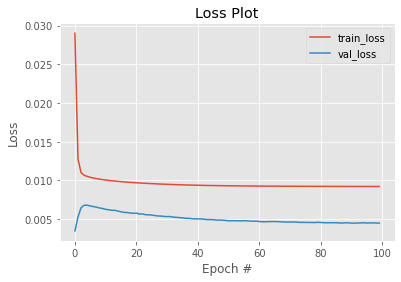

In [53]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

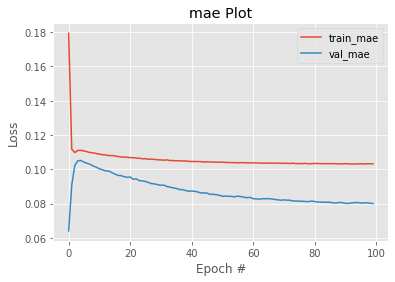

In [54]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mae"], label="train_mae")
plt.plot(np.arange(0, 100), history.history["val_mae"], label="val_mae")
plt.title("mae Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

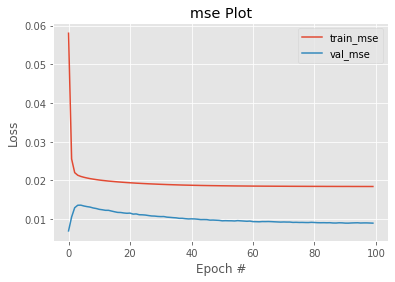

In [55]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mse"], label="train_mse")
plt.plot(np.arange(0, 100), history.history["val_mse"], label="val_mse")
plt.title("mse Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Variabel no2

In [56]:
# no2 = df['no2'].values
no2 = df['no2'].values.reshape(-1, 1)
no2 = min_max_scaler.fit_transform(no2)

In [57]:
minMAE = (no2.max() - no2.min()) * 0.1
minMAE

0.1

In [58]:
split_time = int(0.9 * len(no2))
time_train = time[:split_time]
x_train = no2[:split_time]
time_valid = time[split_time:]
x_valid = no2[split_time:]

In [59]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(3807, 1)


In [60]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(val_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(423, 1)


In [61]:
model_no2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [62]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_no2.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model_no2.fit(train_set, validation_data=(val_set), epochs=100)

Epoch 1/100
473/473 [==============================] - 5s 8ms/step - loss: 0.0032 - mse: 0.0064 - mae: 0.0664 - val_loss: 0.0586 - val_mse: 0.1173 - val_mae: 0.2595
Epoch 2/100
473/473 [==============================] - 3s 7ms/step - loss: 0.0010 - mse: 0.0020 - mae: 0.0349 - val_loss: 0.0526 - val_mse: 0.1053 - val_mae: 0.2388
Epoch 3/100
473/473 [==============================] - 3s 7ms/step - loss: 7.7033e-04 - mse: 0.0015 - mae: 0.0305 - val_loss: 0.0506 - val_mse: 0.1011 - val_mae: 0.2319
Epoch 4/100
473/473 [==============================] - 3s 7ms/step - loss: 7.3076e-04 - mse: 0.0015 - mae: 0.0299 - val_loss: 0.0498 - val_mse: 0.0996 - val_mae: 0.2294
Epoch 5/100
473/473 [==============================] - 3s 7ms/step - loss: 7.2154e-04 - mse: 0.0014 - mae: 0.0298 - val_loss: 0.0494 - val_mse: 0.0988 - val_mae: 0.2281
Epoch 6/100
473/473 [==============================] - 4s 7ms/step - loss: 7.1807e-04 - mse: 0.0014 - mae: 0.0297 - val_loss: 0.0492 - val_mse: 0.0984 - val_mae: 0

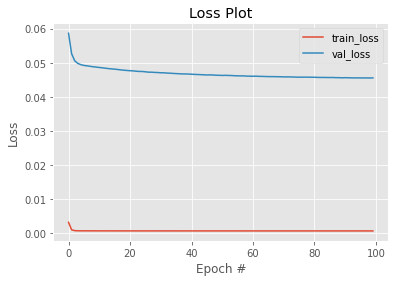

In [63]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

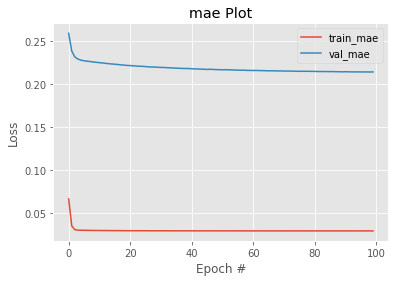

In [64]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mae"], label="train_mae")
plt.plot(np.arange(0, 100), history.history["val_mae"], label="val_mae")
plt.title("mae Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

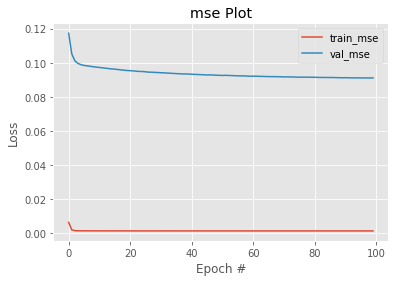

In [65]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mse"], label="train_mse")
plt.plot(np.arange(0, 100), history.history["val_mse"], label="val_mse")
plt.title("mse Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Forecasting

In [407]:
NUM_FORECASTS = 31 #1 bulan
SEED = 1234

##pm10

In [426]:
output_data_pm10 = pd.DataFrame(columns = ["tanggal", "pm10"])

time = df["tanggal"].values[-1]
x_train_pm10 = df['pm10'].values
    
#Buld Model
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)
    
train_set_pm10 = windowed_dataset(x_train_pm10, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history_pm10 = model.fit(train_set_pm10, epochs=1)    

525/525 [==============================] - 4s 6ms/step - loss: 15.4623 - mse: 462.4987 - mae: 15.9547


In [427]:
#Forecasting
data_temp = x_train_pm10.copy()
for j in range(NUM_FORECASTS):
    pm10_forecast = model_forecast(model, data_temp[-window_size:, np.newaxis], batch_size, window_size)
    pm10_forecast = pm10_forecast[:, -1, 0]
    data_temp = np.append(data_temp, round(pm10_forecast[0]))
    time += np.timedelta64(1,'D')
    output_data_pm10 = output_data_pm10.append({"tanggal":time,
                                "pm10":round(pm10_forecast[0])}, 
                                ignore_index=True)

In [428]:
output_data_pm10

,tanggal,pm10
0,2021-08-01,63
1,2021-08-02,63
2,2021-08-03,63
3,2021-08-04,63
4,2021-08-05,63
5,2021-08-06,63
6,2021-08-07,63
7,2021-08-08,63
8,2021-08-09,63
9,2021-08-10,63


##so2

In [429]:
# x_train_co = df['co'].values
# x_train_o3 = df['o3'].values
# x_train_no2 = df['no2'].values

In [430]:
output_data_so2 = pd.DataFrame(columns = ["so2"])

x_train_so2 = df['so2'].values

train_set_so2 = windowed_dataset(x_train_so2, window_size, batch_size, shuffle_buffer_size)
history_so2 = model.fit(train_set_so2, epochs=1)    

525/525 [==============================] - 4s 7ms/step - loss: 4.9716 - mse: 89.4167 - mae: 5.4316


In [431]:
#Forecasting
data_temp_so2 = x_train_so2.copy()
for j in range(NUM_FORECASTS):
    so2_forecast = model_forecast(model, data_temp_so2[-window_size:, np.newaxis], batch_size, window_size)
    so2_forecast = so2_forecast[:, -1, 0]
    data_temp_so2 = np.append(data_temp_so2, round(so2_forecast[0]))
    output_data_so2 = output_data_so2.append({"so2":round(so2_forecast[0])}, 
                                ignore_index=True)
output_data_so2

,so2
0,50
1,50
2,50
3,50
4,50
5,50
6,50
7,50
8,50
9,50


##co

In [432]:
output_data_co = pd.DataFrame(columns = ["co"])

x_train_co = df['co'].values

train_set_co = windowed_dataset(x_train_co, window_size, batch_size, shuffle_buffer_size)
history_co = model.fit(train_set_co, epochs=1)    

525/525 [==============================] - 4s 7ms/step - loss: 9.4969 - mse: 197.3237 - mae: 9.9835


In [433]:
#Forecasting
data_temp_co = x_train_co.copy()
for j in range(NUM_FORECASTS):
    co_forecast = model_forecast(model, data_temp_co[-window_size:, np.newaxis], batch_size, window_size)
    co_forecast = co_forecast[:, -1, 0]
    data_temp_co = np.append(data_temp_co, round(co_forecast[0]))
    output_data_co = output_data_co.append({"co":round(co_forecast[0])}, 
                                ignore_index=True)
output_data_co

,co
0,17
1,16
2,15
3,14
4,13
5,12
6,12
7,12
8,12
9,12


##o3

In [434]:
output_data_o3 = pd.DataFrame(columns = ["o3"])

x_train_o3 = df['o3'].values

train_set_o3 = windowed_dataset(x_train_o3, window_size, batch_size, shuffle_buffer_size)
history_o3 = model.fit(train_set_o3, epochs=1)    

525/525 [==============================] - 4s 7ms/step - loss: 32.2398 - mse: 2038.4353 - mae: 32.7356


In [435]:
#Forecasting
data_temp_o3 = x_train_o3.copy()
for j in range(NUM_FORECASTS):
    o3_forecast = model_forecast(model, data_temp_o3[-window_size:, np.newaxis], batch_size, window_size)
    o3_forecast = o3_forecast[:, -1, 0]
    data_temp_o3 = np.append(data_temp_o3, round(o3_forecast[0]))
    output_data_o3 = output_data_o3.append({"o3":round(o3_forecast[0])}, 
                                ignore_index=True)
output_data_o3

,o3
0,66
1,67
2,68
3,69
4,70
5,71
6,72
7,73
8,74
9,75


##no2

In [436]:
output_data_no2 = pd.DataFrame(columns = ["no2"])

x_train_no2 = df['no2'].values

train_set_no2 = windowed_dataset(x_train_no2, window_size, batch_size, shuffle_buffer_size)
history_no2 = model.fit(train_set_no2, epochs=1)    

525/525 [==============================] - 4s 7ms/step - loss: 5.7754 - mse: 105.4949 - mae: 6.2543


In [437]:
#Forecasting
data_temp_no2 = x_train_no2.copy()
for j in range(NUM_FORECASTS):
    no2_forecast = model_forecast(model, data_temp_no2[-window_size:, np.newaxis], batch_size, window_size)
    no2_forecast = no2_forecast[:, -1, 0]
    data_temp_no2 = np.append(data_temp_so2, round(no2_forecast[0]))
    output_data_no2 = output_data_no2.append({"no2":round(no2_forecast[0])}, 
                                ignore_index=True)
output_data_no2

,no2
0,26
1,23
2,21
3,19
4,17
5,16
6,15
7,14
8,13
9,12


In [438]:
df_predict = pd.DataFrame()
df_predict = pd.concat([output_data_pm10, output_data_so2, output_data_co, output_data_o3, output_data_no2], axis=1)
df_predict

,tanggal,pm10,so2,co,o3,no2
0,2021-08-01,63,50,17,66,26
1,2021-08-02,63,50,16,67,23
2,2021-08-03,63,50,15,68,21
3,2021-08-04,63,50,14,69,19
4,2021-08-05,63,50,13,70,17
5,2021-08-06,63,50,12,71,16
6,2021-08-07,63,50,12,72,15
7,2021-08-08,63,50,12,73,14
8,2021-08-09,63,50,12,74,13
9,2021-08-10,63,50,12,75,12


In [443]:
df_predict.to_csv("air_pollution_prediction.csv", index=False)